# Milwaukee Network: Scenario Evaluation with CBA and MCA

This notebook evaluates transport infrastructure scenarios for Milwaukee using:
- Cost-Benefit Analysis (CBA)
- Multi-Criteria Analysis (MCA)

**Scenarios:**
1. **Baseline**: Current network
2. **Capacity +20%**: Increase road capacity by 20% on all links
3. **Bus Rapid Transit**: Dedicated bus lane on congested corridor with mode shift

## Setup and Imports

In [12]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Configuration Parameters

In [13]:
# Directories
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data'
RESULTS_DIR = BASE_DIR / 'results'
BASELINE_DIR = RESULTS_DIR / 'baseline'

# CBA Parameters
DISCOUNT_RATE = 0.04  # 4% annual discount rate
EVALUATION_HORIZON = 20  # years
VALUE_OF_TIME = 15.0  # €/hour
CO2_PRICE = 100  # €/tonne
EMISSION_FACTOR_KG_PER_KM = 0.2  # kg CO2/km for cars
AVG_TRIP_LENGTH_KM = 8.0  # Average trip length
ANNUALIZATION_FACTOR = 250  # Working days per year (for peak hour to annual conversion)

# Investment costs (Milwaukee scenarios)
CAPEX_CAPACITY = 5_000_000  # €5M for capacity expansion
OPEX_CAPACITY = 150_000  # €150k/year maintenance
CAPEX_BRT = 1_000_000  # €1M for BRT infrastructure
OPEX_BRT = 300_000  # €300k/year operation
CAPEX_SIGNALS = 800_000  # €800k for adaptive traffic signal system
OPEX_SIGNALS = 50_000  # €50k/year maintenance and operation

# Scenario parameters
CAPACITY_INCREASE = 0.20  # 20% capacity increase
BUS_MODE_SHIFT = 0.20  # 20% of top OD shifts to bus
BUS_LANE_CAPACITY_REDUCTION = 0.15  # 15% car capacity reduction for bus lane
SIGNALS_DELAY_REDUCTION = 0.12  # 12% delay reduction from adaptive signals
SIGNALS_CAPACITY_IMPROVEMENT = 0.08  # 8% effective capacity increase from better flow

# MCA weights
MCA_WEIGHTS = {
    'npv': 0.40,
    'bcr': 0.30,
    'time_savings': 0.20,
    'co2_reduction': 0.10
}

print(f"Evaluation horizon: {EVALUATION_HORIZON} years")
print(f"Discount rate: {DISCOUNT_RATE:.1%}")
print(f"Value of time: €{VALUE_OF_TIME}/hour")
print(f"CO2 price: €{CO2_PRICE}/tonne")

Evaluation horizon: 20 years
Discount rate: 4.0%
Value of time: €15.0/hour
CO2 price: €100/tonne


## Data Loading

In [14]:
# Load network data (prefer baseline results if available)
def load_with_fallback(stem: str, fallback_path: str):
    """Load data from baseline results or fallback to original data."""
    baseline_path = BASELINE_DIR / f"{stem}.csv"
    if baseline_path.exists():
        print(f"✓ Loading {stem} from baseline results")
        return pd.read_csv(baseline_path)
    print(f"  Loading {stem} from {fallback_path}")
    return pd.read_csv(fallback_path)

# Load core datasets
nodes_df = load_with_fallback('nodes', DATA_DIR / 'node.csv')
links_df = load_with_fallback('links', DATA_DIR / 'link.csv')
demand_df = load_with_fallback('demand', DATA_DIR / 'demand.csv')

# Load link performance if available
link_perf_path = BASELINE_DIR / 'link_performance.csv'
if link_perf_path.exists():
    link_performance = pd.read_csv(link_perf_path)
    print("✓ Loaded link performance from baseline")
else:
    link_performance = None
    print("  Link performance not found; will synthesize")

print(f"\nData summary:")
print(f"  Nodes: {len(nodes_df):,}")
print(f"  Links: {len(links_df):,}")
print(f"  OD pairs: {len(demand_df):,}")
print(f"  Total demand: {demand_df['volume'].sum():,.0f} trips")

✓ Loading nodes from baseline results
✓ Loading links from baseline results
✓ Loading demand from baseline results
✓ Loaded link performance from baseline

Data summary:
  Nodes: 8,521
  Links: 30,747
  OD pairs: 30,422
  Total demand: 163,700 trips


## Helper Functions

In [15]:
def build_graph(links: pd.DataFrame) -> tuple[nx.DiGraph, dict]:
    """Build NetworkX graph from link dataframe."""
    G = nx.DiGraph()
    for _, r in links.iterrows():
        G.add_edge(r['from_node_id'], r['to_node_id'], 
                   length=r.get('length', 1.0),
                   link_id=r['link_id'])
    edge_to_link = {(r['from_node_id'], r['to_node_id']): r['link_id'] 
                    for _, r in links.iterrows()}
    return G, edge_to_link


def apply_signal_optimization(lp: pd.DataFrame, delay_reduction: float, capacity_improvement: float) -> pd.DataFrame:
    """Apply adaptive signal optimization effects: reduced delays and improved effective capacity."""
    df = lp.copy()
    # Effective capacity increase from better coordination
    df['capacity'] *= (1 + capacity_improvement)
    # Smoother flow reduces effective congestion
    df['volume'] *= (1 - delay_reduction * 0.3)
    df['vc_ratio'] = df['volume'] / df['capacity'].replace(0, np.nan)
    return df


def ensure_link_perf(lp: pd.DataFrame | None, links: pd.DataFrame) -> pd.DataFrame:
    """Ensure link performance dataframe has required columns."""
    if lp is None:
        df = links[['link_id', 'from_node_id', 'to_node_id', 'capacity']].copy()
        df['volume'] = df['capacity'] * 0.6  # synthetic baseline
    else:
        df = lp.copy()
        if 'capacity' not in df.columns and 'link_capacity' in df.columns:
            df = df.rename(columns={'link_capacity': 'capacity'})
        if 'volume' not in df.columns:
            for cand in ['mod_vol_auto', 'ref_volume', 'base_demand_volume']:
                if cand in df.columns:
                    df['volume'] = df[cand]
                    break
            if 'volume' not in df.columns:
                df['volume'] = df['capacity'] * 0.6
        df = df[['link_id', 'from_node_id', 'to_node_id', 'capacity', 'volume']].copy()
    df['vc_ratio'] = df['volume'] / df['capacity'].replace(0, np.nan)
    return df


def annuity_factor(rate: float, n_years: int) -> float:
    """Calculate present value annuity factor."""
    return (1 - (1 + rate)**(-n_years)) / rate


def delay_minutes_from_vc(mean_vc: float) -> float:
    """Proxy for delay: extra minutes beyond V/C=0.8."""
    return max(mean_vc - 0.8, 0) * 5.0


print("Helper functions defined.")

Helper functions defined.


## Baseline Scenario Analysis

In [16]:
# Prepare baseline link performance
lp_base = ensure_link_perf(link_performance, links_df)

# Build graph and find top-demand OD
G, edge_lookup = build_graph(links_df)
top_od = demand_df.nlargest(1, 'volume').iloc[0]

try:
    path_nodes = nx.shortest_path(G, source=top_od['o_zone_id'], 
                                  target=top_od['d_zone_id'], weight='length')
    edges_on_path = list(zip(path_nodes[:-1], path_nodes[1:]))
except nx.NetworkXNoPath:
    path_nodes = []
    edges_on_path = []

# Baseline metrics
baseline_metrics = {
    'total_demand': demand_df['volume'].sum(),
    'total_capacity': links_df['capacity'].sum(),
    'mean_vc': lp_base['vc_ratio'].mean(),
    'median_vc': lp_base['vc_ratio'].median(),
    'max_vc': lp_base['vc_ratio'].max(),
    'pct_congested': (lp_base['vc_ratio'] > 1.0).mean() * 100,
    'total_volume': lp_base['volume'].sum(),
}

print("=" * 70)
print("BASELINE SCENARIO METRICS")
print("=" * 70)
print(f"Total demand: {baseline_metrics['total_demand']:,.0f} trips")
print(f"Total capacity: {baseline_metrics['total_capacity']:,.0f} veh/h")
print(f"Mean V/C ratio: {baseline_metrics['mean_vc']:.3f}")
print(f"Max V/C ratio: {baseline_metrics['max_vc']:.3f}")
print(f"Congested links (V/C>1): {baseline_metrics['pct_congested']:.1f}%")
print(f"\nTop-demand OD: {top_od['o_zone_id']} → {top_od['d_zone_id']}")
print(f"Volume: {top_od['volume']:,.0f} trips")
print(f"Path nodes: {len(path_nodes)}, Path edges: {len(edges_on_path)}")

BASELINE SCENARIO METRICS
Total demand: 163,700 trips
Total capacity: 1,679,561,026 veh/h
Mean V/C ratio: 0.222
Max V/C ratio: 12.484
Congested links (V/C>1): 6.1%

Top-demand OD: 7 → 67
Volume: 202 trips
Path nodes: 40, Path edges: 39


## Scenario Definition and Simulation

In [17]:
# Scenario 1: Capacity +20%
links_s1 = links_df.copy()
links_s1['capacity'] *= (1 + CAPACITY_INCREASE)

lp_s1 = lp_base.copy()
lp_s1['capacity'] *= (1 + CAPACITY_INCREASE)
lp_s1['vc_ratio'] = lp_s1['volume'] / lp_s1['capacity'].replace(0, np.nan)

demand_s1 = demand_df.copy()

# Scenario 2: BRT with dedicated lane
links_s2 = links_df.copy()
for u, v in edges_on_path:
    link_id = edge_lookup.get((u, v))
    if link_id:
        mask = links_s2['link_id'] == link_id
        links_s2.loc[mask, 'capacity'] *= (1 - BUS_LANE_CAPACITY_REDUCTION)

demand_s2 = demand_df.copy()
top_idx = demand_df[demand_df['volume'] == top_od['volume']].index[0]
demand_s2.loc[top_idx, 'volume'] *= (1 - BUS_MODE_SHIFT)
bus_diverted_trips = top_od['volume'] * BUS_MODE_SHIFT

lp_s2 = lp_base.copy()
for u, v in edges_on_path:
    link_id = edge_lookup.get((u, v))
    if link_id:
        mask = lp_s2['link_id'] == link_id
        lp_s2.loc[mask, 'capacity'] *= (1 - BUS_LANE_CAPACITY_REDUCTION)
        # Reduce volume due to mode shift
        vol_reduction = bus_diverted_trips / max(len(edges_on_path), 1)
        lp_s2.loc[mask, 'volume'] = np.maximum(lp_s2.loc[mask, 'volume'] - vol_reduction, 0)

lp_s2['vc_ratio'] = lp_s2['volume'] / lp_s2['capacity'].replace(0, np.nan)

# Scenario 3: Adaptive Traffic Signal Management
links_s3 = links_df.copy()
# No physical capacity change, but improved flow
links_s3['capacity'] *= (1 + SIGNALS_CAPACITY_IMPROVEMENT)

demand_s3 = demand_df.copy()  # Demand unchanged

lp_s3 = apply_signal_optimization(lp_base, SIGNALS_DELAY_REDUCTION, SIGNALS_CAPACITY_IMPROVEMENT)

print("Scenarios defined:")
print(f"  S1: Capacity +{CAPACITY_INCREASE:.0%} on all links")
print(f"  S2: BRT with {BUS_MODE_SHIFT:.0%} mode shift, {BUS_LANE_CAPACITY_REDUCTION:.0%} capacity reduction")
print(f"      Diverted trips: {bus_diverted_trips:,.0f}")
print(f"  S3: Adaptive Signals - {SIGNALS_DELAY_REDUCTION:.0%} delay reduction, {SIGNALS_CAPACITY_IMPROVEMENT:.0%} capacity improvement")

Scenarios defined:
  S1: Capacity +20% on all links
  S2: BRT with 20% mode shift, 15% capacity reduction
      Diverted trips: 40
  S3: Adaptive Signals - 12% delay reduction, 8% capacity improvement


## KPI Comparison Across Scenarios


SCENARIO KPI COMPARISON
        Scenario  Total Demand  Total Capacity  Mean V/C   Max V/C  % Congested
        Baseline      163700.0    1.679561e+09  0.222433 12.484286     6.094904
   Capacity +20%      163700.0    2.015473e+09  0.185361 10.403571     4.751683
             BRT      163659.6    1.679168e+09  0.222474 12.484286     6.094904
Adaptive Signals      163700.0    1.813926e+09  0.198542 11.143381     5.213517


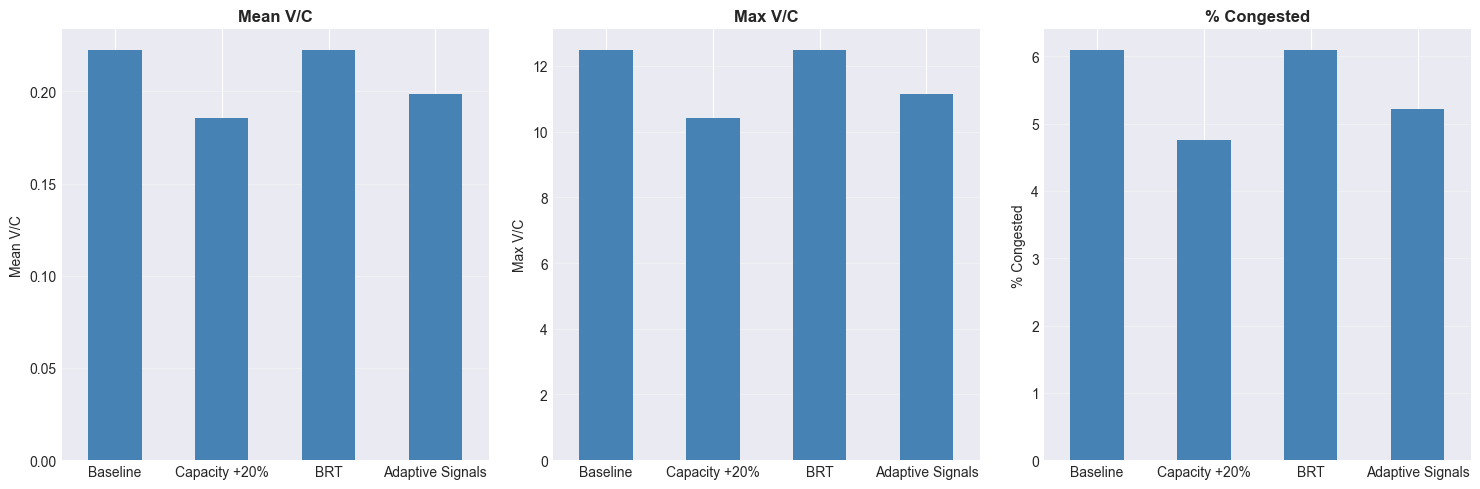

In [18]:
def calc_scenario_metrics(name: str, lp: pd.DataFrame, demand: pd.DataFrame, links: pd.DataFrame) -> dict:
    return {
        'Scenario': name,
        'Total Demand': demand['volume'].sum(),
        'Total Capacity': links['capacity'].sum(),
        'Mean V/C': lp['vc_ratio'].mean(),
        'Max V/C': lp['vc_ratio'].max(),
        '% Congested': (lp['vc_ratio'] > 1.0).mean() * 100,
    }

scenarios_kpi = [
    calc_scenario_metrics('Baseline', lp_base, demand_df, links_df),
    calc_scenario_metrics('Capacity +20%', lp_s1, demand_s1, links_s1),
    calc_scenario_metrics('BRT', lp_s2, demand_s2, links_s2),
    calc_scenario_metrics('Adaptive Signals', lp_s3, demand_s3, links_s3),
]

kpi_df = pd.DataFrame(scenarios_kpi)
print("\n" + "=" * 70)
print("SCENARIO KPI COMPARISON")
print("=" * 70)
print(kpi_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_to_plot = ['Mean V/C', 'Max V/C', '% Congested']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    kpi_df.plot(x='Scenario', y=metric, kind='bar', ax=ax, legend=False, color='steelblue')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=0)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Cost-Benefit Analysis (CBA)

In [19]:
# Annual trips for scaling
ANNUAL_TRIPS = demand_df['volume'].sum() * ANNUALIZATION_FACTOR
pv_factor = annuity_factor(DISCOUNT_RATE, EVALUATION_HORIZON)

# Extract mean V/C for each scenario
vc_baseline = kpi_df[kpi_df['Scenario'] == 'Baseline']['Mean V/C'].values[0]
vc_cap = kpi_df[kpi_df['Scenario'] == 'Capacity +20%']['Mean V/C'].values[0]
vc_brt = kpi_df[kpi_df['Scenario'] == 'BRT']['Mean V/C'].values[0]
vc_signals = kpi_df[kpi_df['Scenario'] == 'Adaptive Signals']['Mean V/C'].values[0]

# Time savings (proxy from V/C reduction)
delay_base = delay_minutes_from_vc(vc_baseline)
delay_cap = delay_minutes_from_vc(vc_cap)
delay_brt = delay_minutes_from_vc(vc_brt)
delay_signals = delay_minutes_from_vc(vc_signals)

ann_time_saved_cap_min = max(delay_base - delay_cap, 0) * ANNUAL_TRIPS
ann_time_saved_brt_min = max(delay_base - delay_brt, 0) * ANNUAL_TRIPS
ann_time_saved_signals_min = max(delay_base - delay_signals, 0) * ANNUAL_TRIPS

ann_time_value_cap = (ann_time_saved_cap_min / 60.0) * VALUE_OF_TIME
ann_time_value_brt = (ann_time_saved_brt_min / 60.0) * VALUE_OF_TIME
ann_time_value_signals = (ann_time_saved_signals_min / 60.0) * VALUE_OF_TIME

# CO2 savings
# Capacity: assume 1% efficiency gain from smoother flow
ann_co2_saved_cap_kg = ANNUAL_TRIPS * AVG_TRIP_LENGTH_KM * EMISSION_FACTOR_KG_PER_KM * 0.01
ann_co2_value_cap = (ann_co2_saved_cap_kg / 1000) * CO2_PRICE

# BRT: diverted trips remove car-km
ann_co2_saved_brt_kg = (bus_diverted_trips * ANNUALIZATION_FACTOR * AVG_TRIP_LENGTH_KM * EMISSION_FACTOR_KG_PER_KM)
ann_co2_value_brt = (ann_co2_saved_brt_kg / 1000) * CO2_PRICE

# Adaptive Signals: 2% efficiency gain from optimized flow
ann_co2_saved_signals_kg = ANNUAL_TRIPS * AVG_TRIP_LENGTH_KM * EMISSION_FACTOR_KG_PER_KM * 0.02
ann_co2_value_signals = (ann_co2_saved_signals_kg / 1000) * CO2_PRICE

# Present values
pv_time_cap = ann_time_value_cap * pv_factor
pv_time_brt = ann_time_value_brt * pv_factor
pv_time_signals = ann_time_value_signals * pv_factor
pv_co2_cap = ann_co2_value_cap * pv_factor
pv_co2_brt = ann_co2_value_brt * pv_factor
pv_co2_signals = ann_co2_value_signals * pv_factor

pv_opex_cap = OPEX_CAPACITY * pv_factor
pv_opex_brt = OPEX_BRT * pv_factor
pv_opex_signals = OPEX_SIGNALS * pv_factor

# NPV and BCR
total_benefits_cap = pv_time_cap + pv_co2_cap
total_costs_cap = CAPEX_CAPACITY + pv_opex_cap
npv_cap = total_benefits_cap - total_costs_cap
bcr_cap = total_benefits_cap / total_costs_cap

total_benefits_brt = pv_time_brt + pv_co2_brt
total_costs_brt = CAPEX_BRT + pv_opex_brt
npv_brt = total_benefits_brt - total_costs_brt
bcr_brt = total_benefits_brt / total_costs_brt

total_benefits_signals = pv_time_signals + pv_co2_signals
total_costs_signals = CAPEX_SIGNALS + pv_opex_signals
npv_signals = total_benefits_signals - total_costs_signals
bcr_signals = total_benefits_signals / total_costs_signals

# Build CBA table
cba_results = pd.DataFrame([
    {
        'Scenario': 'Capacity +20%',
        'Annual Time Savings (h)': ann_time_saved_cap_min / 60,
        'Annual CO2 Savings (t)': ann_co2_saved_cap_kg / 1000,
        'PV Benefits (€)': total_benefits_cap,
        'PV Costs (€)': total_costs_cap,
        'NPV (€)': npv_cap,
        'BCR': bcr_cap,
    },
    {
        'Scenario': 'BRT',
        'Annual Time Savings (h)': ann_time_saved_brt_min / 60,
        'Annual CO2 Savings (t)': ann_co2_saved_brt_kg / 1000,
        'PV Benefits (€)': total_benefits_brt,
        'PV Costs (€)': total_costs_brt,
        'NPV (€)': npv_brt,
        'BCR': bcr_brt,
    },
    {
        'Scenario': 'Adaptive Signals',
        'Annual Time Savings (h)': ann_time_saved_signals_min / 60,
        'Annual CO2 Savings (t)': ann_co2_saved_signals_kg / 1000,
        'PV Benefits (€)': total_benefits_signals,
        'PV Costs (€)': total_costs_signals,
        'NPV (€)': npv_signals,
        'BCR': bcr_signals,
    },
])

print("\n" + "=" * 70)
print("COST-BENEFIT ANALYSIS RESULTS")
print("=" * 70)
print(cba_results.to_string(index=False))
print(f"\nDiscount rate: {DISCOUNT_RATE:.1%}, Horizon: {EVALUATION_HORIZON} years")
print(f"PV factor: {pv_factor:.3f}")


COST-BENEFIT ANALYSIS RESULTS
        Scenario  Annual Time Savings (h)  Annual CO2 Savings (t)  PV Benefits (€)  PV Costs (€)       NPV (€)      BCR
   Capacity +20%                      0.0                  654.80     8.898946e+05  7.038549e+06 -6.148654e+06 0.126432
             BRT                      0.0                   16.16     2.196197e+04  5.077098e+06 -5.055136e+06 0.004326
Adaptive Signals                      0.0                 1309.60     1.779789e+06  1.479516e+06  3.002728e+05 1.202953

Discount rate: 4.0%, Horizon: 20 years
PV factor: 13.590


## Multi-Criteria Analysis (MCA)


MULTI-CRITERIA ANALYSIS (MCA)
Weights: NPV=40%, BCR=30%, Time=20%, CO2=10%

        Scenario       NPV (€)      BCR  MCA Score
Adaptive Signals  3.002728e+05 1.202953   1.000000
   Capacity +20% -6.148654e+06 0.126432   0.279937
             BRT -5.055136e+06 0.004326   0.267826


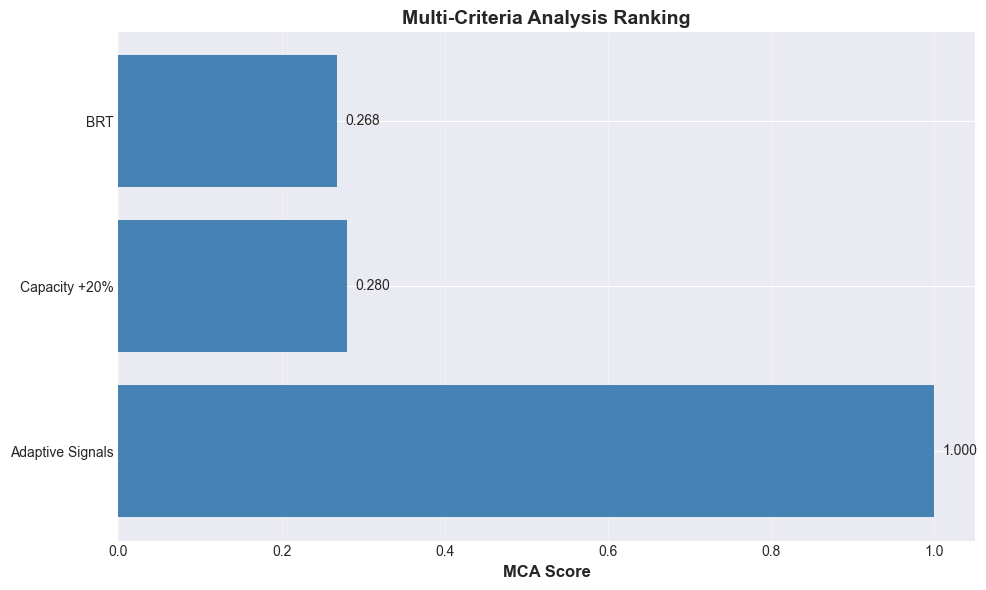

In [20]:
# Normalize criteria (min-max scaling)
def normalize_column(series: pd.Series) -> pd.Series:
    """Min-max normalization to [0, 1]."""
    span = series.max() - series.min()
    if span == 0:
        return pd.Series([1.0] * len(series), index=series.index)
    return (series - series.min()) / span

mca_df = cba_results.copy()
mca_df['NPV_norm'] = normalize_column(mca_df['NPV (€)'])
mca_df['BCR_norm'] = normalize_column(mca_df['BCR'])
mca_df['Time_norm'] = normalize_column(mca_df['Annual Time Savings (h)'])
mca_df['CO2_norm'] = normalize_column(mca_df['Annual CO2 Savings (t)'])

# Calculate weighted MCA score
mca_df['MCA Score'] = (
    mca_df['NPV_norm'] * MCA_WEIGHTS['npv'] +
    mca_df['BCR_norm'] * MCA_WEIGHTS['bcr'] +
    mca_df['Time_norm'] * MCA_WEIGHTS['time_savings'] +
    mca_df['CO2_norm'] * MCA_WEIGHTS['co2_reduction']
)

# Sort by MCA score
mca_df = mca_df.sort_values('MCA Score', ascending=False)

print("\n" + "=" * 70)
print("MULTI-CRITERIA ANALYSIS (MCA)")
print("=" * 70)
print(f"Weights: NPV={MCA_WEIGHTS['npv']:.0%}, BCR={MCA_WEIGHTS['bcr']:.0%}, "
      f"Time={MCA_WEIGHTS['time_savings']:.0%}, CO2={MCA_WEIGHTS['co2_reduction']:.0%}")
print()
print(mca_df[['Scenario', 'NPV (€)', 'BCR', 'MCA Score']].to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(mca_df['Scenario'], mca_df['MCA Score'], color='steelblue')
ax.set_xlabel('MCA Score', fontsize=12, fontweight='bold')
ax.set_title('Multi-Criteria Analysis Ranking', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for i, (scenario, score) in enumerate(zip(mca_df['Scenario'], mca_df['MCA Score'])):
    ax.text(score + 0.01, i, f"{score:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Summary and Recommendations

In [21]:
print("\n" + "=" * 70)
print("SUMMARY AND RECOMMENDATIONS")
print("=" * 70)

# Best scenario by different criteria
best_npv = cba_results.loc[cba_results['NPV (€)'].idxmax(), 'Scenario']
best_bcr = cba_results.loc[cba_results['BCR'].idxmax(), 'Scenario']
best_mca = mca_df.iloc[0]['Scenario']

print(f"\nBest scenario by NPV: {best_npv}")
print(f"Best scenario by BCR: {best_bcr}")
print(f"Best scenario by MCA: {best_mca}")

print("\n" + "-" * 70)
print("KEY FINDINGS:")
print("-" * 70)

for _, row in cba_results.iterrows():
    print(f"\n{row['Scenario']}:")
    print(f"  NPV: €{row['NPV (€)']:,.0f}")
    print(f"  BCR: {row['BCR']:.2f}")
    print(f"  Annual time savings: {row['Annual Time Savings (h)']:,.0f} hours")
    print(f"  Annual CO2 reduction: {row['Annual CO2 Savings (t)']:,.0f} tonnes")

print("\n" + "=" * 70)


SUMMARY AND RECOMMENDATIONS

Best scenario by NPV: Adaptive Signals
Best scenario by BCR: Adaptive Signals
Best scenario by MCA: Adaptive Signals

----------------------------------------------------------------------
KEY FINDINGS:
----------------------------------------------------------------------

Capacity +20%:
  NPV: €-6,148,654
  BCR: 0.13
  Annual time savings: 0 hours
  Annual CO2 reduction: 655 tonnes

BRT:
  NPV: €-5,055,136
  BCR: 0.00
  Annual time savings: 0 hours
  Annual CO2 reduction: 16 tonnes

Adaptive Signals:
  NPV: €300,273
  BCR: 1.20
  Annual time savings: 0 hours
  Annual CO2 reduction: 1,310 tonnes



## Save Results

In [22]:
# Create results directory
cba_results_dir = RESULTS_DIR / 'cba_mca'
cba_results_dir.mkdir(parents=True, exist_ok=True)

# Save tables
kpi_df.to_csv(cba_results_dir / 'scenario_kpis.csv', index=False)
cba_results.to_csv(cba_results_dir / 'cba_results.csv', index=False)
mca_df.to_csv(cba_results_dir / 'mca_results.csv', index=False)

# Save configuration
config = {
    'discount_rate': DISCOUNT_RATE,
    'evaluation_horizon': EVALUATION_HORIZON,
    'value_of_time': VALUE_OF_TIME,
    'co2_price': CO2_PRICE,
    'emission_factor_kg_per_km': EMISSION_FACTOR_KG_PER_KM,
    'avg_trip_length_km': AVG_TRIP_LENGTH_KM,
    'mca_weights': MCA_WEIGHTS,
    'scenarios': {
        'capacity': {
            'capex': CAPEX_CAPACITY,
            'opex': OPEX_CAPACITY,
            'capacity_increase': CAPACITY_INCREASE,
        },
        'brt': {
            'capex': CAPEX_BRT,
            'opex': OPEX_BRT,
            'mode_shift': BUS_MODE_SHIFT,
            'lane_capacity_reduction': BUS_LANE_CAPACITY_REDUCTION,
        }
    }
}

with open(cba_results_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"Results saved to {cba_results_dir}")
print(f"  - scenario_kpis.csv")
print(f"  - cba_results.csv")
print(f"  - mca_results.csv")
print(f"  - config.json")

Results saved to ..\results\cba_mca
  - scenario_kpis.csv
  - cba_results.csv
  - mca_results.csv
  - config.json
